<a href="https://colab.research.google.com/github/furqoncreative/clusterling-bisecting-kmeans/blob/master/Bisecting_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

In [58]:
url = 'https://raw.githubusercontent.com/furqoncreative/data-mining-eclat/master/movie_metadata.csv'
dataset=pd.read_csv(url)
dataset.fillna(value=0,axis=1,inplace=True)
dataset.head(7)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,0,Doug Walker,0.0,0.0,131.0,0.0,Rob Walker,131.0,0.0,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,143,0,0.0,0,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,0.0,0,0,0,0.0,0.0,12.0,7.1,0.00,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|prin...,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0


In [49]:
df = pd.DataFrame(dataset)
cols = [22,8]
df = df[df.columns[cols]]
df.dropna(subset = ["budget"], inplace=True)
df.dropna(subset = ["gross"], inplace=True)
display(df)

,budget,gross
0,237000000.0,760505847.0
1,300000000.0,309404152.0
2,245000000.0,200074175.0
3,250000000.0,448130642.0
4,0.0,0.0
...,...,...
5038,0.0,0.0
5039,0.0,0.0
5040,1400.0,0.0
5041,0.0,10443.0


In [31]:
data = df.to_numpy()
print(data)

[[2.37000000e+08 7.60505847e+08]
 [3.00000000e+08 3.09404152e+08]
 [2.45000000e+08 2.00074175e+08]
 ...
 [1.40000000e+03 0.00000000e+00]
 [0.00000000e+00 1.04430000e+04]
 [1.10000000e+03 8.52220000e+04]]


In [19]:
def get_intra(clt, data):
    total_dist = 0
    for i in clt:
        for j in clt:
            dist = (data[i] - data[j]) ** 2
            dist = dist.sum()
            dist = dist ** 0.5
            total_dist = total_dist + dist

    return total_dist / (len(clt) * len(clt))

In [50]:
def get_inter(clt1, clt2, data):
    total_dist = 0
    for i in clt1:
        for j in clt2:
            dist = (data[i] - data[j]) ** 2
            dist = dist.sum()
            dist = dist ** 0.5
            total_dist = total_dist + dist

    return total_dist / (len(clt1) * len(clt2))

In [55]:
def get_center(data_idx, data):
    center = np.zeros(2, dtype='float')
    for i in data_idx:
        center = center + data[i]

    return center / len(data_idx)

In [52]:
def get_SSE(data_idx, data, center):
    part_data = []
    for i in data_idx:
        part_data.append(data[i])
    sse = (center - part_data) ** 2
    sse = sse.sum(axis=1)
    sse = sse.sum(axis=0)
    return sse

In [62]:
def kmeans(k, data_idx, data, cls_res, center_idx, cluster_number):
    center_list = random.sample(data_idx, k)
    cls_center = []
    temp_cls_res = []
    temp_cls_res.extend(cls_res)

    for i in center_list:
        cls_center.append(data[i])

    while True:
        is_changed = 0
        cls_count = np.zeros(k, dtype=float)
        cls_avg = np.zeros([k, 2])
        sse_idx1 = []
        sse_idx2 = []
        for i in data_idx:
            point = data[i]
            dist = (point - cls_center) ** 2
            dist = dist.sum(axis=1)
            dist = dist ** 0.5
            min = dist.argsort()[0]
            cls_avg[min] = cls_avg[min] + data[i]
            if min == 0:
                temp_cls_res[i] = center_idx
            else:
                temp_cls_res[i] = cluster_number

            cls_count[min] = cls_count[min] + 1

        for i in range(0, k):
            avg = cls_avg[i] / cls_count[i]  
            if not (np.array_equal(np.array(cls_center[i]), avg)):
                cls_center[i] = avg
                is_changed = 1

        if is_changed == 0:
            break

    for i in data_idx:
        if temp_cls_res[i] == center_idx:
            sse_idx1.append(i)
        else:
            sse_idx2.append(i)
    sse1 = get_SSE(sse_idx1, data, cls_center[0])
    sse2 = get_SSE(sse_idx2, data, cls_center[1])
    return cls_center, temp_cls_res, [sse1, sse2]

In [63]:
def bisecting(k, data):
    cls_center = []
    cls_SSE = np.zeros(k, dtype='float')
    cls_start = np.zeros(2, dtype='float')
    cls_res = np.zeros(len(data), dtype='int')
    cls_count = np.zeros(k, dtype='int')
    for i in data:
        print(i)
        cls_start = cls_start + i
        cls_start = cls_start / len(data)
        cls_center.append(cls_start)

    while len(cls_center) < k: 
        cls_count = np.zeros(k, dtype=float)
        cls_avg = np.zeros([k, 2])

        if len(cls_center) == 1:
            for i in range(0, len(cls_center)):
                cmp_SSE = []
                data_idx = []
                for j in range(0, len(data)):
                    if cls_res[j] == i:
                        data_idx.append(j)
            center, temp_res, sse_list = kmeans(2, data_idx, data, cls_res, 0, 1)

            cls_center = center
            cls_res = temp_res
            cls_SSE[0] = sse_list[0]
            cls_SSE[1] = sse_list[1]
        else:
            temp_SSE = []
            temp_center = []
            cmp_SSE = []
            res = []
            for i in range(0, len(cls_center)):
                data_idx = []
                for j in range(0, len(data)):
                    if cls_res[j] == i:
                        data_idx.append(j)

                center, temp_res, sse_list = kmeans(2, data_idx, data, cls_res, i, len(cls_center))
                sse_list.append(cls_SSE[i])
                res.append(temp_res)
                temp_center.append(center)
                temp_SSE.append(sse_list)
            for i in temp_SSE:  
                cmp_SSE.append(i[2] - i[0] - i[1])
            min = np.array(cmp_SSE).argsort()[len(cmp_SSE) - 1]
            cls_center[min] = temp_center[0]
            cls_center.append(temp_center[1])
            cls_res = res[min]
            cls_SSE[min] = temp_SSE[min][0]
            cls_SSE[len(cls_center) - 1] = temp_SSE[min][1]
        # print("RES = ", count_result(cls_res))
    for i in range(0, len(data)):
        cls_count[cls_res[i]] = cls_count[cls_res[i]] + 1

    return cls_res

Streaming output truncated to the last 5000 lines.
[2.00000000e+08 4.14984497e+08]
[2.00000000e+08 1.25320003e+08]
[1.9000000e+08 3.5003411e+08]
[1.90000000e+08 2.02351611e+08]
[2.00000000e+08 2.33914986e+08]
[1.90000000e+08 2.28756232e+08]
[1.950000e+08 6.517186e+07]
[1.05000000e+08 1.44812796e+08]
[2.0000000e+08 9.0755643e+07]
[1.90000000e+08 1.01785482e+08]
[1.95000000e+08 3.52358779e+08]
[1.85000000e+08 3.17011114e+08]
[0.00000000e+00 1.23070338e+08]
[1.85000000e+08 2.37282182e+08]
[1.85000000e+08 1.30468626e+08]
[1.80000000e+08 2.23806889e+08]
[1.4000000e+08 1.4008085e+08]
[2.00000000e+08 1.66112167e+08]
[2.00000000e+08 1.37850096e+08]
[1.7600000e+08 4.7375327e+07]
[1.80000000e+08 1.24051759e+08]
[1.80000000e+08 2.91709845e+08]
[1.78000000e+08 1.54985087e+08]
[1.85000000e+08 5.33316061e+08]
[1.75000000e+08 2.92979556e+08]
[1.75000000e+08 1.98332128e+08]
[1.4000000e+08 3.1829818e+08]
[1.7000000e+08 7.3820094e+07]
[1.70000000e+08 1.13745408e+08]
[1.45000000e+08 1.02176165e+08]
[1.75

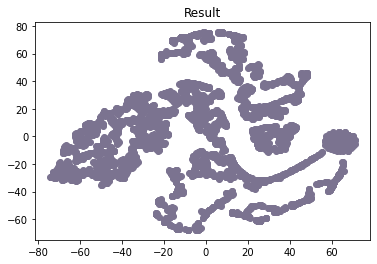

In [ ]:
k = 4
cls_res = bisecting(k, data)
cls_count = np.zeros(k, dtype='int')
for i in range(0, len(data)):
    cls_count[cls_res[i]] = cls_count[cls_res[i]] + 1

model = TSNE(learning_rate=100)
transformed = model.fit_transform(data)

collection_list = []
intra_class = []
inter_class = []
sse_list = []
for i in range(0, k):
    result = []
    xs = []
    ys = []
    for j in range(0, len(data)):
        if cls_res[j] == i:
            xs.append(transformed[j][0])
            ys.append(transformed[j][1])
            result.append(j)
    plt.title("Result")
    plt.scatter(xs, ys, c=[np.random.rand(3, )])

    collection_list.append(result)
plt.show()

for i in range(0, len(collection_list)):
    for j in range(i, len(collection_list)):
        if i == j:
            intra_class.append(get_intra(collection_list[j], data))
            sse_list.append(get_SSE(collection_list[i], data, get_center(collection_list[i], data)))
        else:
            inter_class.append(get_inter(collection_list[i], collection_list[j], data))

print("intra = ", intra_class, np.mean(intra_class), np.var(intra_class), np.std(intra_class))
print("inter = ", inter_class, np.mean(inter_class), np.var(inter_class), np.std(inter_class))
print("SSE = ", sse_list, np.mean(sse_list), np.var(sse_list), np.std(sse_list))